In [1]:
import json
from pprint import pprint
import matplotlib
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from pymongo import MongoClient
import pandas as pd

In [2]:
def parse_configs(config_path):
    with open(config_path, 'r') as f:
        configs = json.load(f)
    return configs

def setup_mongo(configs):
    mongo_client = MongoClient(configs['connection_string'])
    speedtest_db = mongo_client[configs['db_name']]
    collection = speedtest_db[configs['collection_name']]
    return collection

In [3]:
configs = parse_configs('configs.json')
coll = setup_mongo(configs)

In [4]:
pipeline = [
    {
        "$match": {
            "wifi_name": "ArlemaCom 14"
        }
    },
    {
        "$project": {
            "_id": 0,
            "download_mb": 1,
            "upload_mb": 1,
            "ping": 1,
            "measured": 1
        }
    },
    {
        "$group": {
            "_id": None,
            "times": { 
                "$push": "$measured"
            },
            "uploads": {
                "$push": "$upload_mb"
            },
            "downloads": {
                "$push": "$download_mb"
            },
            "pings": {
                "$push": "$ping"
            }
        }
    },
    {
        "$project": {
            "_id": 0
        }
    },
]

res = list(coll.aggregate(pipeline))[0]

In [10]:
times, downloads, uploads, pings = res['times'], res['downloads'], res['uploads'], res['pings']
df = pd.DataFrame(downloads)
avg_down = df.rolling(window=1).mean()
avg_down.fillna(0, inplace=True)
avg_down = avg_down.__array__()

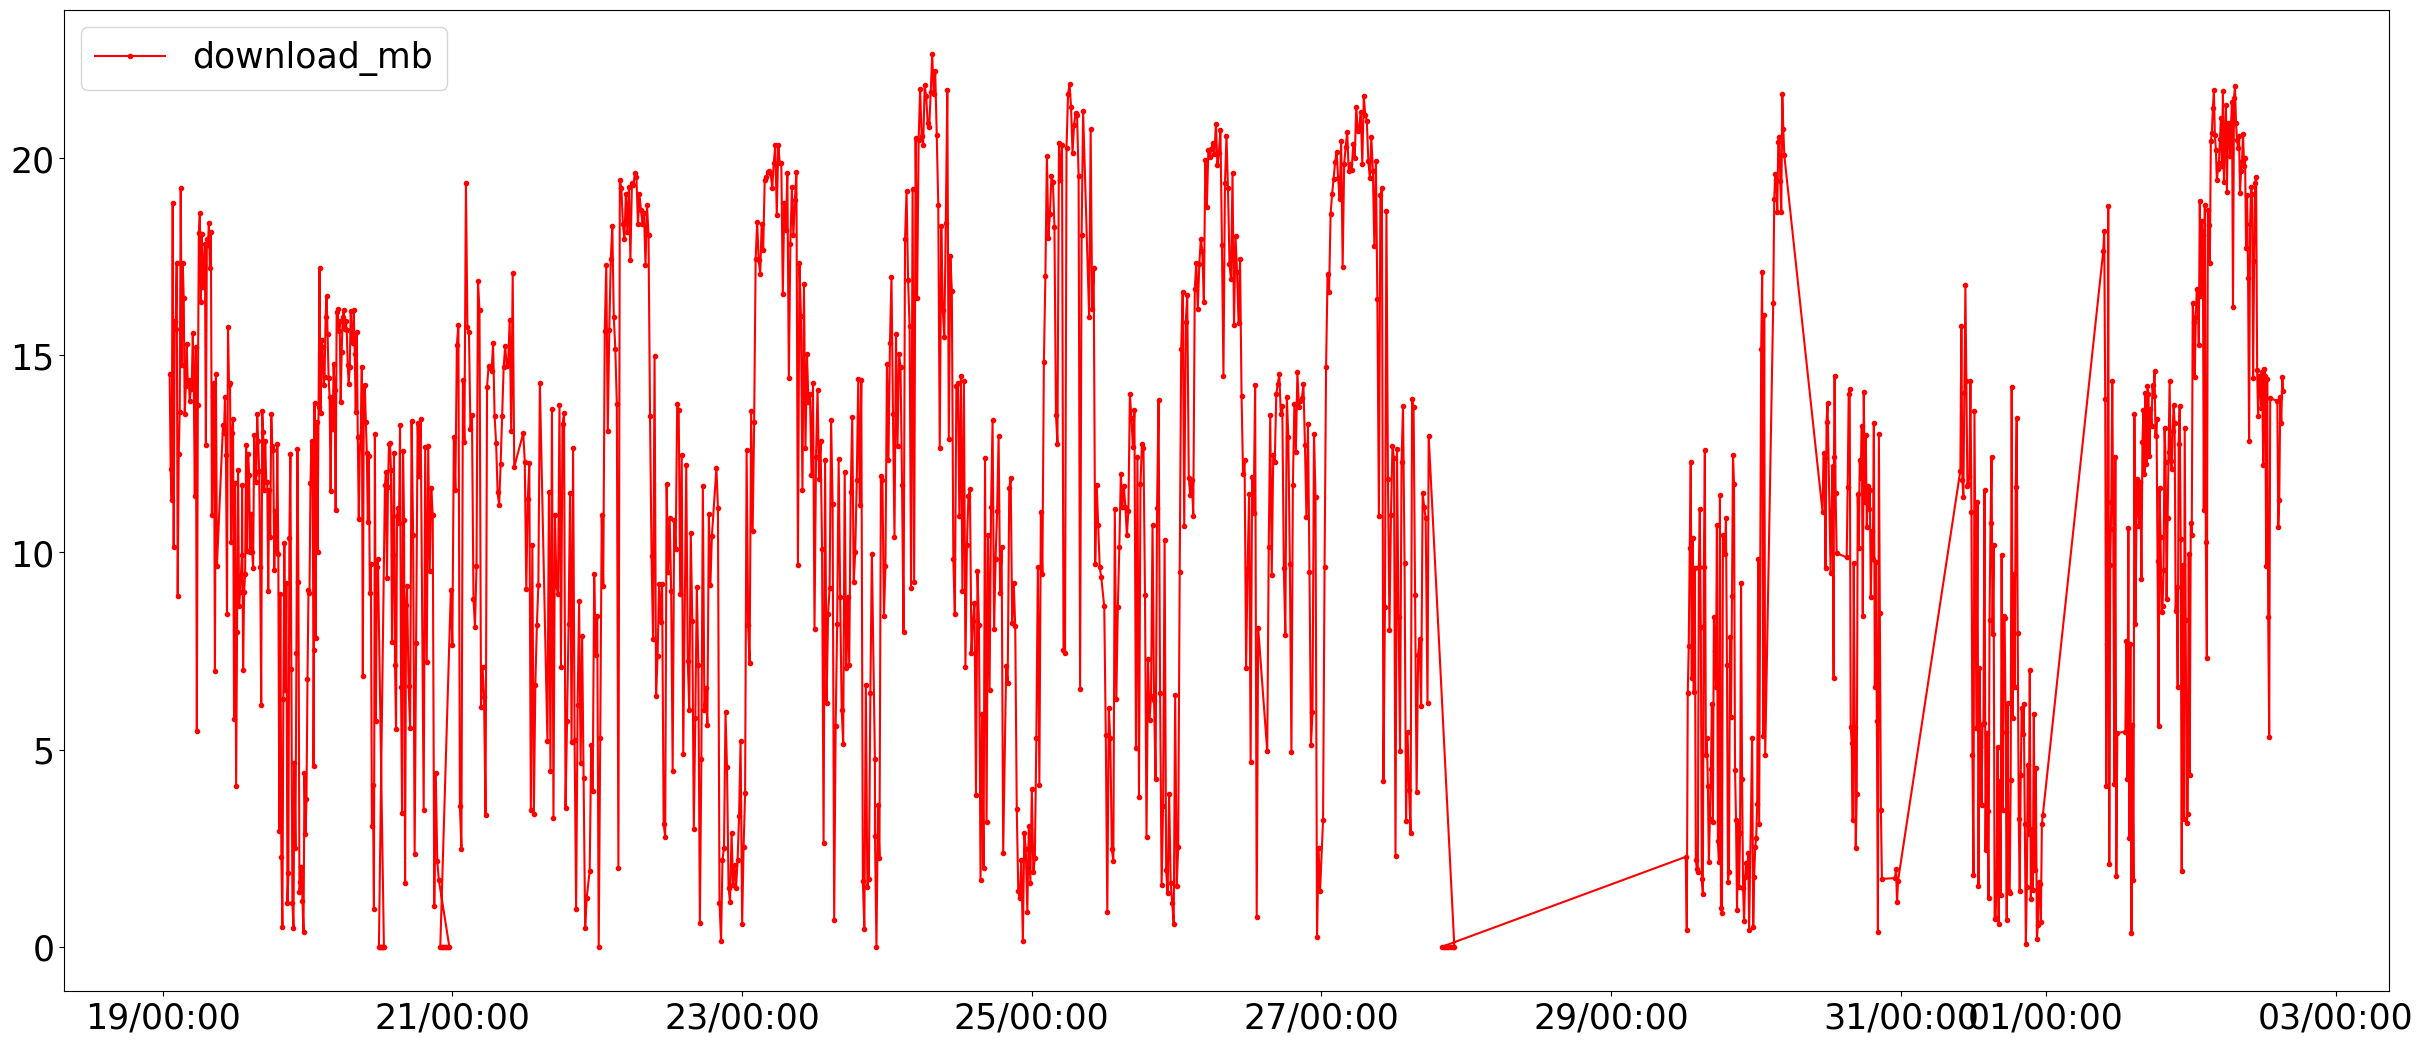

In [11]:
plt.figure(num=None, figsize=(30, 13), dpi=100, facecolor='w', edgecolor='k')
matplotlib.rc('xtick', labelsize=25)
matplotlib.rc('ytick', labelsize=25)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%H:%M'))
plt.plot(times, avg_down, '.r-', label='download_mb')
# plt.plot(times, uploads, '.b-', label='upload_mb')
plt.legend(fontsize=25)